## Step 1: Query all Annoated Corn Images from 2021

In [1]:
import pandas as pd
import time
import numpy as np
from matplotlib import pyplot as plt, rcParams

import brtdevkit
from brtdevkit.core.db import DBConnector, DatetimeFilter
from brtdevkit.core.db.db_filters import *  # We need this for pre-defined filters, e.g., ProjectFilter, DatetimeFilter

from warnings import filterwarnings
filterwarnings("ignore")

def get_shasta_data(filters={}, start=None, end=None, limit=None):
    """
    Query relevant Shasta data for calculations. 
    """
    start_time = time.time()
    connector = DBConnector()
    img_filters = {'project_name': 'shasta', **filters}
    if start is not None or end is not None:
        img_filters = [img_filters, DatetimeFilter(key="collected_on", start=start, end=end)]
    df = connector.get_documents_df('image', img_filters, limit=limit)
    elapsed_time = time.time() - start_time
    return df, elapsed_time

start = datetime(2021,3,29) # The first field was collected on 3/30/2021
end = datetime(2021, 10, 1)

filters = {"artifacts.kind": "nrg", 
           'crop_name': 'CORN',
           'has_human_annotation': True
          }

corn_df, elapsed_time = get_shasta_data(filters=filters, start=start, end=end)
corn_df['grower_farm_field'] = corn_df['grower'] + '_' + corn_df['farm'] + '_' + corn_df['operating_field_name']
print(f"Queried {len(corn_df)} images in {elapsed_time:.2f} s.")

Queried 15061 images in 25.30 s.


### Step 2: Remove any identical lat / long / camera_serial combinations

In [2]:
start_len = len(corn_df)
corn_df = corn_df.drop_duplicates(subset=['latitude', 'longitude', 'camera_serial'], keep='first')
print(f'{start_len - len(corn_df)} images were removed due to Identical Lat/Long/Camera_serial combos.')

35 images were removed due to Identical Lat/Long/Camera_serial combos.


## Step 3: Check for Low Solar Angles

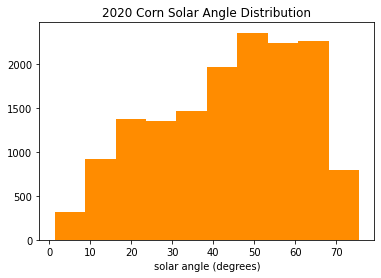

There are 179 corn images from 2 fields with < 5 degree solar angles.


In [3]:
# Code to add solar_angle numbers to the dataframe

import datetime
from timezonefinder import TimezoneFinderL
import pytz
from pysolar.solar import *

# You can instantiate the TimezoneFinder() oject inside the function if needed, but it will slow down the computation about 15%
tf = TimezoneFinderL()

def get_solar_angle(timestamp, latitude, longitude):
    """
    Requires datetime, TimezonefinderL, pytz and pysolar libraries
    
    Inputs: Timestamp, latitude, longitude.
    Outputs: Solar angle between (-90 , 90). Daylight conditions will always be > 0.
    """
    # Localize and adjust UTC timestamps to local timezone
    utc = pytz.utc.localize(timestamp)
    tz = tf.timezone_at(lat=latitude, lng=longitude)
    adjusted_timestamp = utc.astimezone(tz)

    # If there are invalid GPS coordinates, the function will return 'NaN'
    if adjusted_timestamp.tzinfo is not None:
        return get_altitude(latitude, longitude, adjusted_timestamp)
    else:
        return float('NaN')

# apply to brtdevkit DataFrame with 'collected_on', 'latitude' and 'longitude' columns
corn_df['solar_angle'] = corn_df.apply(lambda x: get_solar_angle(x['collected_on'], x['latitude'], x['longitude']), axis=1)
plt.hist(corn_df['solar_angle'], color='darkorange')
plt.title('2020 Corn Solar Angle Distribution')
plt.xlabel('solar angle (degrees)')
plt.show()

print(f'There are {len(corn_df[corn_df.solar_angle < 5])} corn images from {len(corn_df[corn_df.solar_angle < 5].operating_field_name.unique())} fields with < 5 degree solar angles.')

In [4]:
print(len(corn_df))
corn_df=corn_df[corn_df['solar_angle']>= 5]
print(len(corn_df))

15026
14847


## Step 4: Validate Annotations (most recent version, have s3_keys, etc)

In [5]:
# Flatten annotations to make them easily searchable

def flatten_annotations(dataframe):
    r = pd.DataFrame(
        {
            col:np.repeat(dataframe[col].values, dataframe['annotations'].str.len())
            for col in dataframe.columns.drop('annotations')
        }).assign(**{'annotations':np.concatenate(dataframe['annotations'].values)})[dataframe.columns]
    w = pd.concat([
        r.drop(['annotations'], axis=1),
        r['annotations'].apply(pd.Series).add_suffix('_annotations')
    ],
    axis=1)
    # Return filtered dataframe with each annotation artifact as a single row. 
    # Filter out ndvi and machine labels, as well as labels in a state other than ok. 
    return w[(w['kind_annotations'] != 'machine') & (w['kind_annotations'] != 'ndvi_mask') & (w['state_annotations']=='ok')]

flat = flatten_annotations(corn_df)
print(f'There are {len(flat)} total annotations from {len(flat._id.unique())} unique image ids')

There are 18570 total annotations from 13756 unique image ids


In [6]:
# Reomove any annotations that have a more recent version (from an audit or correction)

flat = flat[flat.next_version_annotations.isnull()==True]
flat.next_version_annotations.isnull().value_counts()

True    14174
Name: next_version_annotations, dtype: int64

In [7]:
# Sort for the most recent annotations of each id
flat = flat.sort_values(by='created_at_annotations', ascending =True, axis=0)

# Romove any duplicate image ids
# annotations_final is now our master list of annotations used to create the annotation datasets
annotations_final = flat.drop_duplicates(subset=['_id'], keep='last')
print(f'There are {len(annotations_final)} annotated images that are valid.')

There are 13737 annotated images that are valid.


In [8]:
# Verify all annotations are pixelwise style 
annotations_final.style_annotations.value_counts()

pixelwise    13737
Name: style_annotations, dtype: int64

In [9]:
# Creating string versions of some metadata fields to be able to search through them. (There's probably a better way to do this)
annotations_final['nv'] = annotations_final.next_version_annotations.astype(str)
annotations_final['lm'] = annotations_final.label_map_annotations.astype(str)
annotations_final['s3k'] = annotations_final.s3_key_annotations.apply(str)
annotations_final['s3b'] = annotations_final.s3_bucket_annotations.apply(str)

# There are now no images with nans for label_map, s3_bucket and s3_key
print(len(annotations_final[(annotations_final['lm']== 'nan') | (annotations_final['s3k']== 'nan') | (annotations_final['s3b']== 'nan')]))
# There are no annotations with next_version is not null (meaning there is no newer version)
print(len(annotations_final[annotations_final.nv.isnull()==True]))

# This cell should output zeros and only one label map. Otherwise, there is something wrong. 
annotations_final['lm'].value_counts()

0
0


{'1': 'weed', '2': 'crop'}    13737
Name: lm, dtype: int64

In [10]:
# Look at which label policies were used

annotations_final['lp'] = annotations_final.label_policy_annotations.astype(str)

# This next line removes a cotton field that was mislabeled as corn
annotations_final = annotations_final[annotations_final['lp']!='6083224ccfbd2a9d788f2988']
# Should now just be all '607653583f4e7e93319cc306' which is the corn label policy
print(annotations_final.lp.value_counts())

607653583f4e7e93319cc306    13656
Name: lp, dtype: int64


## Step 5: Choose minimum annotations threshold and assign growers to folds

In [21]:
from itertools import compress

# Set threshold of minimum number of labeled images per field
image_threshold = 0

bool_list = [(len(annotations_final[annotations_final['grower_farm_field'] == field]) >= image_threshold) for field in annotations_final.grower_farm_field.unique() ]
sufficient_labels = list(compress(annotations_final.grower_farm_field.unique(), bool_list))
print(f'There are {len(sufficient_labels)} fields above the {image_threshold} annotation threshold')

# number of images for each field to date
annotations_final[annotations_final['grower_farm_field'].isin(sufficient_labels)].grower_farm_field.value_counts()

There are 100 fields above the 0 annotation threshold


Chris Hajovsky CLH Farms_Dolesh_Dolesh    240
dunn farms_morgan city_MO-4               240
Brantley Farming CO_Rice Trus_1374-1      240
Paul Bert_Paul Bert_19&24 NE2             239
dunn farms_morgan city_MO-7               239
                                         ... 
Bri-Mac_MCLEOD_branyon 80                  76
Dusten Oehme s_Oehme s Farm_4th st         71
Stuart Briggman_Briggman west_8            42
john haug_John home_southwest              41
Brandon Andel_Andel home_Home ranch        39
Name: grower_farm_field, Length: 100, dtype: int64

In [22]:
# When ready, limit the annotations to just the fields with sufficient labels
chosen_fields = annotations_final[annotations_final['grower_farm_field'].isin(sufficient_labels)]
labels_2021 = chosen_fields[['_id', 'grower','_id_annotations']]

print(f'There are {len(labels_2021)} images from {len(chosen_fields.grower_farm_field.unique())} fields ready to use.')

There are 13656 images from 100 fields ready to use.


## Examine fields on map

In [13]:
# Examine Fields in Map to Ensure They are Unique
import folium

fields = chosen_fields.groupby('grower_farm_field').median().reset_index()[['grower_farm_field','latitude', 'longitude']]

# Generate base_map for adding points
def generateBaseMap(default_location=[36, -100], default_zoom_start=4.25):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map
base_map = generateBaseMap()

# Add fields to the base_map
for i in range(len(fields)):
    folium.Marker(location=[fields.latitude[i], fields.longitude[i]],popup= fields.grower_farm_field[i]).add_to(base_map)

base_map

## Load 2020 Datasets and Merge With the New 2021 Data

In [23]:
from brtdevkit.data import Dataset

holdout_2020 = Dataset.retrieve(name = "Q2_2021_Holdout_Test_Set_Corn_Annotation_v0.2").to_dataframe()[['id','grower','annotation_pixelwise_0__id']]
all_folds_2020 =Dataset.retrieve(name = "Q2_2021_Corn_Annotation_All_Folds_v0").to_dataframe()[['id','grower','annotation_pixelwise_0__id']]
hq_test = Dataset.retrieve(name = "Q2_2021_HIGH_QUALITY_Corn_Annotation_All_Folds_Plus_Holdout_v0").to_dataframe()[['id','grower','annotation_pixelwise_0__id']]

print(len(all_folds_2020))
revised_train = all_folds_2020[~all_folds_2020['id'].isin(hq_test['id'])]
print(len(revised_train))

38089
37240


In [26]:
# Dictionary of grower names to fix { incorrect_name : correct_name }
fix_grower_names = {'allen below': 'Allen Below',
                    'andrew butcher':'Andrew Butcher',
                    'brian brekken':'Brian Brekken',
                    'Pual Burt': 'Paul Bert', 
                   'Steven Beakly' : 'Steven Beakley',
                    'Beakley' : 'Steven Beakley',
                   'beakley' : 'Steven Beakley',
                   'Brantley Farming CO': 'Brantley Farming Co',
                   'Brantley Farms Co': 'Brantley Farming Co',
                   'Jeff Baize': 'Jeff Blaize',
                   'Brantley Farming CO':'Brantley Farming Co',
                   'Brantley Farms Co':'Brantley Farming Co',
                    'Stuart Briggerman':'Stuart Briggman',
                    'Beakley':'Steven Beakley',
                   'beakley':'Steven Beakley',
                   'brian brekken':'Brian Brekken',
                    'Chris Hajovsky CLH farms': 'Chris Hajovsky CLH Farms',
                    'dejoux':'Charlie Dejoux',
                    'kent heiman': 'kent Heiman',
                    'Jensen':'Jensen Farms',
                    'brad nichol':'brad nichols',
                    'jason summers': 'Jason Summers',
                    'oehme farms llc': 'Dustin Oehme',
                    'oehme farms': 'Dustin Oehme',
                    'oehmefarms': 'Dustin Oehme',
                    'Dustin Oehme s': 'Dustin Oehme',
                    'ra pickens':'RA Pickens',
                    'craig warner': 'Craig warner',
                    'craigwarner': 'Craig warner',
                    'jerem heine': 'jeremy heine',
                    'jim buesing':'jim Buesing',
                    'klye mehrkens':'kyle mehrkens',
                    'matt jones': 'Matt Jones',
                    'nick elser': 'Nick Elser',
                    'nick erickson':'Nick Erickson',
                    'nikki meyer':'Nikki Meyer',
                    'nikki meyers':'Nikki Meyer',
                    'Schronk Agri' : 'Todd Schronk', 
                    'MikeDice':'Mike Dice'
                   }

revised_train['grower'] = revised_train['grower'].map(fix_grower_names).fillna(revised_train['grower'])
print(f'After cleaning, there are {len(revised_train.grower.unique())} unique growers in the trainging set.')
holdout_2020['grower'] = holdout_2020['grower'].map(fix_grower_names).fillna(holdout_2020['grower'])
print(f'After cleaning, there are {len(holdout_2020.grower.unique())} unique growers in the 2020 test set.')
labels_2021['grower'] = labels_2021['grower'].map(fix_grower_names).fillna(labels_2021['grower'])
print(f'After cleaning, there are {len(labels_2021.grower.unique())} unique growers in the 2021 data.')

# Drops any of the same growers in train/test from the train set
revised_train = revised_train[~revised_train['grower'].isin(list(holdout_2020.grower.unique()))]

# Splits for Train / Test / Dev are:
# 83, 24, 12

total_unique = len(set(list(labels_2021.grower.unique()) + list(holdout_2020.grower.unique()) + list(revised_train.grower.unique())))
print(f'We now have {total_unique} unique growers to split.')

After cleaning, there are 59 unique growers in the trainging set.
After cleaning, there are 15 unique growers in the 2020 test set.
After cleaning, there are 47 unique growers in the 2021 data.
We now have 119 unique growers to split.


## Assign growers to Train / Test / Dev


In [27]:
# rename columns to be consistent
labels_2021.columns = ['id','grower','annotation_id']
holdout_2020.columns = ['id','grower','annotation_id']
revised_train.columns = ['id','grower','annotation_id']

overlap_train = labels_2021[labels_2021['grower'].isin(revised_train['grower'].unique())].grower.unique()
print(f'{len(overlap_train)} growers from 2021 are present in the train set')

overlap_test = labels_2021[labels_2021['grower'].isin(holdout_2020['grower'].unique())].grower.unique()
print(f'{len(overlap_test)} growers from 2021 are present in the test set')
all_growers_2020_2019 = list(holdout_2020['grower'].unique()) + list(revised_train['grower'].unique())

no_overlap = labels_2021[~labels_2021['grower'].isin(all_growers_2020_2019)].grower.unique()
print(f'{len(no_overlap)} growers from 2021 are not present in any older dataset')

1 growers from 2021 are present in the train set
1 growers from 2021 are present in the test set
45 growers from 2021 are not present in any older dataset


In [28]:
# Create Dev set from growers not present in the train or test datasets
# Number of growers is 20 or 10% of total
from random import shuffle
shuffle(no_overlap)

n_dev_growers = 12
dev_growers =  no_overlap[0:n_dev_growers]
no_overlap = no_overlap[n_dev_growers:]

dev_set = labels_2021[labels_2021['grower'].isin(dev_growers)]
print(f'There are {len(dev_set.grower.unique())} growers in the dev set and {len(dev_set)} labeled images.')
print(f'there are now {len(no_overlap)} growers still available')

There are 12 growers in the dev set and 3893 labeled images.
there are now 33 growers still available


In [29]:
# Create Test set

test_2021 = labels_2021[labels_2021['grower'].isin(holdout_2020['grower'].unique())]
final_test = pd.concat([holdout_2020, test_2021], axis=0)
still_needed = 24 - len(final_test.grower.unique())
print(f'We need {still_needed} more growers to get to 20%')
new_test_growers = no_overlap[0:still_needed]
no_overlap= no_overlap[still_needed:]
print(f'There are still {len(no_overlap)} growers available.')
#
final_test = pd.concat([final_test, labels_2021[labels_2021['grower'].isin(new_test_growers)]], axis=0)
len(final_test.grower.unique())

We need 9 more growers to get to 20%
There are still 24 growers available.


24

In [30]:
# Create Train Set

train_2021 = labels_2021[labels_2021['grower'].isin(revised_train['grower'].unique())]

final_train = pd.concat([revised_train, train_2021], axis=0)

still_needed = 83 - len(final_train.grower.unique())
print(f'We need {still_needed} more growers to get to 70%')
new_train_growers = no_overlap[0:still_needed]
print(len(new_train_growers))
no_overlap= no_overlap[still_needed:]
print(f'There are now {len(no_overlap)} growers left over.')
final_train = pd.concat([final_train, labels_2021[labels_2021['grower'].isin(new_train_growers)]], axis=0)
len(final_train.grower.unique())

We need 24 more growers to get to 70%
24
There are now 0 growers left over.


83

In [34]:
# confirm removal of hq test images (should output 0)
print(len(revised_train[revised_train['id'].isin(hq_test['id'])]))

0


In [31]:
# Check for overlapping ids between new train and old test, new test and old train. Shoould output all zeros. 

print(len(final_train[final_train.id.isin(holdout_2020.id.unique())].id.unique()))
print(len(final_test[final_test.id.isin(revised_train.id.unique())].id.unique()))

0
0


In [32]:
# Check for any growers present in different sets. Should output all zeros

print(len(final_train[final_train.grower.isin(final_test.grower.unique())].grower.unique()))
print(len(final_train[final_train.grower.isin(dev_set.grower.unique())].grower.unique()))
print(len(final_test[final_test.grower.isin(final_train.grower.unique())].grower.unique()))
print(len(final_test[final_test.grower.isin(dev_set.grower.unique())].grower.unique()))
print(len(dev_set[dev_set.grower.isin(final_test.grower.unique())].grower.unique()))
print(len(dev_set[dev_set.grower.isin(final_train.grower.unique())].grower.unique()))

0
0
0
0
0
0


In [33]:
# Check for any annotation_ids present in multiple sets. Should output all zeros

print(len(final_train[final_train.annotation_id.isin(final_test.annotation_id.unique())].annotation_id.unique()))
print(len(final_train[final_train.annotation_id.isin(dev_set.annotation_id.unique())].annotation_id.unique()))
print(len(final_test[final_test.annotation_id.isin(final_train.annotation_id.unique())].annotation_id.unique()))
print(len(final_test[final_test.annotation_id.isin(dev_set.annotation_id.unique())].annotation_id.unique()))
print(len(dev_set[dev_set.annotation_id.isin(final_test.annotation_id.unique())].annotation_id.unique()))
print(len(dev_set[dev_set.annotation_id.isin(final_train.annotation_id.unique())].annotation_id.unique()))

0
0
0
0
0
0


## Final Step: Format Lists of Annotation IDs and Create Datasets

In [35]:
print(len(dev_set))
print(len(dev_set.grower.unique()))
dev_list = list(dev_set.annotation_id.astype(str))
print(len(dev_list))
dev_list[0:5]
#dev_set.head()

3893
12
3893


['607a6146302d8d2b780b52d0',
 '607a6146302d8d2b780b5303',
 '607a7dbb1f92eaa43c86a3e7',
 '607a7f2cfe73c238529906bd',
 '607a7fc1fe73c2385299072d']

In [37]:
print(len(final_test))
print(len(final_test.grower.unique()))
test_list = list(final_test.annotation_id.astype(str))
print(len(test_list))
test_list[0:5]

14698
24
14698


['5ee1e96abbc907ec4d82cf8b',
 '5ee1e96abbc907ec4d82cf91',
 '5ee1e96abbc907ec4d82cf97',
 '5ee1e96abbc907ec4d82cf99',
 '5ee1e96abbc907ec4d82cf9f']

In [36]:
print(len(final_train))
print(len(final_train.grower.unique()))
train_list = list(final_train.annotation_id.astype(str))
print(len(train_list))
train_list[0:5]

43802
83
43802


['5ee1e934fa286fc5b734d6b5',
 '5ee1e934fa286fc5b734d6b7',
 '5ee1e934fa286fc5b734d6b9',
 '5ee1e934fa286fc5b734d6bb',
 '5ee1e934fa286fc5b734d6bd']

## Finally, create the dataset

In [40]:
from brtdevkit.data import Dataset

# Enter a name and description
dataset_name= '062821_Corn_Dev_Set_v1'
description = 'A Dev set of corn data from 2021 containing images from 12 different growers.'

Dataset.create(
    name= dataset_name,
    description = description,
    kind = Dataset.KIND_ANNOTATION,
    annotation_ids = dev_list
    )

{}

In [41]:
# After a few minutes, retreive the dataset to verify it has been created properly

dset = Dataset.retrieve(name = dataset_name)
print(len(dset.to_dataframe()))
dset

3893


{'created_at': '2021-06-28T21:12:44.145000',
 'created_by': '5eb9c57bb291053fb00bc70c',
 'description': 'A Dev set of corn data from 2021 containing images from 12 different growers.',
 'id': '60da3b4cb4615a40352e0db6',
 'is_deleted': False,
 'kind': 'annotation',
 'metadata_s3_bucket': 'tartarus.datasets',
 'metadata_s3_key': 'prod/annotation/60da3b4cb4615a40352e0db6.jsonl',
 'name': '062821_Corn_Dev_Set_v1',
 'parameters': {},
 'request_s3_location': {'s3_bucket': 'tartarus.datasets',
  's3_key': 'prod/dataset_request/5eb9c57bb291053fb00bc70c_40a4790aedbf461c9b7e5f78eb9f6281.json'},
 'state': 'ready',
 'updated_at': '2021-06-28T21:12:44.145000'}

## Bonus Round: Create Subsampled Test Sets for Consensus Labeling

In [ ]:
# Load Test Set
from brtdevkit.data import Dataset

test_corn = Dataset.retrieve(name = "062821_Corn_Test_Set_v1").to_dataframe()
test_corn['grower_farm_field'] = test_corn['grower'] + '_' + test_corn['farm'] + '_' + test_corn['operating_field_name']
np.min(test_corn.grower_farm_field.value_counts())

In [20]:
from random import shuffle

sample_ids = []

#in the future when you upgrade to pandas 1.1 use this next line:
# sampled = test_corn.groupby("grower_farm_field").apply(sample(n=30, random_state=1))

for f in test_corn.grower_farm_field.unique():
    sub = test_corn[test_corn['grower_farm_field']==f]
    
    sub_id = list(sub['annotation_pixelwise_0__id'])
    shuffle(sub_id)
    sample_ids = sample_ids + (sub_id[0:30])

print(len(sample_ids))
print(len(test_corn.grower_farm_field.unique())*30)
sample_ids[0:5]

1200
1200


['600e929bfb8f42e2c65e4cb8',
 '600e45f7de7d6b3790844987',
 '6007dfd4f0e92f8599b6e655',
 '5fc342b776684a80e64323b1',
 '5ff57246e317600492963c59']

In [21]:
# Enter a name and description
dataset_name= '062821_Corn_Subsampled_Test_Set_v1'
description = 'A subsampled test set of 062821_Corn_Test_Set_v1, with 30 images randomly chosen per field.'

Dataset.create(
    name= dataset_name,
    description = description,
    kind = Dataset.KIND_ANNOTATION,
    annotation_ids = sample_ids
    )

{}